# CRI iAtlas notebooks

## Build a Random Forest model with ICI data

    Repo: https://github.com/CRI-iAtlas/iatlas-notebooks/ 
    Notebook: ici_models_elastic_net.ipynb 
    Date: November 20, 2021 
    Author: Carolina Heimann

---

notebook repo: https://github.com/CRI-iAtlas/iatlas-notebooks

landing page: https://www.cri-iatlas.org/

portal: https://isb-cgc.shinyapps.io/shiny-iatlas/

email: support@cri-iatlas.org

---

Welcome to the CRI iAtlas notebooks. With these notebooks you'll be able to recreate many of our figures and modules found in the web portal, but with your own data or configuration. In this case, you will be able to reproduce the workflow implemented in the ICI Machine Learning module to build models with data from Immune Checkpoint Inhibitor (ICI) datasets, and adapt it to your preferred modeling strategy.

This is a jupyter notebook running R. The fastest way to get started is to open the notebook using Jupyter lab in MyBinder, it's free and works great.

If you want to run this on your local environment, you'll need Jupyter and an R kernel to use it.<br>
See [this conda guide](https://docs.anaconda.com/anaconda/navigator/tutorials/r-lang/) or [this datacamp guide](https://www.datacamp.com/community/blog/jupyter-notebook-r) to get started.<br>

## Getting started

In [27]:
# We have a few libraries to install.
try({
    packages = c("magrittr", "wrapr", "dplyr", "tidyr", "plotly", "caret", "glmnet", "survminer", 
                 "dplyr", "arrow", "tidyr", "ggplot2", "pROC", "pheatmap", "knitr", "ggfortify", "iatlas.api.client")

    sapply(packages, function(x) {
      if (!require(x,character.only = TRUE))
        install.packages(x)
        suppressPackageStartupMessages(library(x,character.only = TRUE))
    })

    # and our iatlas package from github
    if (!require(iatlas.modules)) {
      devtools::install_github("CRI-iAtlas/iatlas.modules")
      suppressPackageStartupMessages(library(iatlas.modules))
    }},
    silent=TRUE 
)

Next we need to read our collection of helper functions found in the 'notebook_functions.R' file.

We have a function that organizes the output of queries to the iAtlas database into the format that is required to run training functions in the `caret` package.

Here we'll use source to bring them in.

In [28]:
# git clone the notebook repo to get this file #
# or see: https://github.com/CRI-iAtlas/iatlas-notebooks/blob/main/functions/notebook_functions.R
source('functions/notebook_functions.R')

---
---

# Exploring the ICI datasets and available predictors

This portion of the notebook will explore the ICI data available in iAtlas for modeling.

The iAtlas ICI data is stored in a database that can be queried with functions from the `iatlas.api.client` package. 
We have clinical data, immune features, scores of predictors of response to immunotherapy, and quantile normalized gene expression.

You can get more information in iAtlas on [immune features and predictors of response to ICI](https://isb-cgc.shinyapps.io/shiny-iatlas/?module=datainfo), and our annotation of [immunomodulators](https://isb-cgc.shinyapps.io/shiny-iatlas/?module=immunomodulators) genes. You can access more information about these datasets in [iAtlas - ICI Datasets Overview](https://isb-cgc.shinyapps.io/shiny-iatlas/?module=ioresponse_overview) module.

As a first step, let's take a look at the available datasets and features. We will query values for samples of interest in the next section.

In [29]:
#getting ICI data
#datasets that we have in the iAtlas database
ici_datasets <- iatlas.api.client::query_datasets(types = "ici")
ici_datasets

display,name,type
<chr>,<chr>,<chr>
"Choueiri 2016 - KIRC, PD-1",Choueiri_CCR_2016,ici
"Gide 2019 - SKCM, PD-1 +/- CTLA4",Gide_Cell_2019,ici
"Hugo 2016 - SKCM, PD-1",HugoLo_IPRES_2016,ici
"IMmotion150 - KIRC, PD-L1",IMmotion150,ici
"IMVigor210 - BLCA, PD-L1",IMVigor210,ici
"Kim 2018 - STAD, PD-1",Kim_NatMed_2018,ici
"Liu 2019 - SKCM, PD-1",Liu_NatMed_2019,ici
"Miao 2018 - KIRC, PD-1 +/- CTLA4, PD-L1",Miao_Science_2018,ici
"Prins 2019 - GBM, PD-1",Prins_GBM_2019,ici


The display name of the datasets makes reference to the publication associated with the data, and also summarises the tumor type and ICI target involved in the study.

In [30]:
#immune features of all samples in the ici datasets
features_df <- iatlas.api.client::query_features(cohorts = ici_datasets$name)
head(features_df)

name,display,class,order,unit,method_tag
<chr>,<chr>,<chr>,<int>,<chr>,<chr>
B_cells_Aggregate2,B Cells,Immune Cell Proportion - Common Lymphoid and Myeloid Cell Derivative Class,3,Fraction,CIBERSORT
B_cells_Aggregate3,B Cells,Immune Cell Proportion - Differentiated Lymphoid and Myeloid Cell Derivative Class,4,Fraction,CIBERSORT
B_cells_memory,B Cells Memory,Immune Cell Proportion - Original,9,Fraction,CIBERSORT
B_cells_naive,B Cells Naive,Immune Cell Proportion - Original,8,Fraction,CIBERSORT
BIOCARTA_CTLA4_V_Bindea_Th1_Cells,CTLA4 vs Th1,Predictor of Response to Immune Checkpoint Treatment,NA,Fraction,NA
Cytolytic_Score,Cytolytic Score,Predictor of Response to Immune Checkpoint Treatment,NA,Score,NA


In [31]:
#clinical annotation that is available for the ici datasets
clinical_options <- iatlas.api.client::query_tags(datasets = ici_datasets$name)
head(clinical_options)

tag_name,tag_long_display,tag_short_display,tag_characteristics,tag_color,tag_order,tag_type
<chr>,<chr>,<chr>,<chr>,<lgl>,<int>,<chr>
Biopsy_Site,Biopsy Site,Biopsy Site,Site where sample was collected from.,NA,18,parent_group
Cancer_Tissue,Cancer Tissue,Cancer Tissue,Original tumor tissue.,NA,14,parent_group
Clinical_Benefit,Clinical Benefit,Clinical Benefit,Patients have clinical benefit when mRECIST response is different than Progressive Disease.,NA,4,parent_group
Clinical_Stage,Clinical Stage,Clinical Stage,Clinical stage of cancer.,NA,17,parent_group
FFPE,FFPE Samples,FFPE Samples,Indicates whether the sample is FFPE or not.,NA,20,parent_group
gender,Gender,Gender,NA,NA,NA,parent_group


In [32]:
#genes that we have expression data for all samples in the ici datasets (we will query expression values in the next section)
genes_df <- iatlas.api.client::query_genes(cohorts = ici_datasets$name)
head(genes_df)

hgnc,entrez,description,friendly_name,io_landscape_name,gene_family,gene_function,immune_checkpoint,pathway,super_category
<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
A1BG,1,NA,NA,NA,NA,NA,NA,NA,NA
A1BG-AS1,503538,NA,NA,NA,NA,NA,NA,NA,NA
A1CF,29974,NA,NA,NA,NA,NA,NA,NA,NA
A2M,2,NA,NA,NA,NA,NA,NA,NA,NA
A2M-AS1,144571,NA,NA,NA,NA,NA,NA,NA,NA
A2ML1,144568,NA,NA,NA,NA,NA,NA,NA,NA


The independent variable to be used in the model corresponds to how a patient responds to immunotherapy. The response to therapy with Immune Checkpoint Inhitbitor is originally annotated following the guidelines of mRECIST, and has 4 different levels.

In [33]:
iatlas.api.client::query_tags(parent_tags = "Response") %>% 
    dplyr::arrange(tag_order)

tag_name,tag_long_display,tag_short_display,tag_characteristics,tag_color,tag_order,tag_type
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>
complete_response_response,Complete Response,Complete Response,Complete Response (CR) following modified Response Evaluation Criteria in Solid Tumors (mRECIST) guidelines,#70C1B3,1,group
partial_response_response,Partial Response,Partial Response,Partial Response (PR) following modified Response Evaluation Criteria in Solid Tumors (mRECIST) guidelines,#247BA0,2,group
stable_disease_response,Stable Disease,Stable Disease,Stable Disease (SD) following modified Response Evaluation Criteria in Solid Tumors (mRECIST) guidelines,#FFE066,3,group
progressive_disease_response,Progressive Disease,Progressive Disease,Progressive Disease (PD) following modified Response Evaluation Criteria in Solid Tumors (mRECIST) guidelines,#F25F5C,4,group
na_response,Not available,Not available,Response information not available,#868A88,5,group


We will use as possible outcome variable Responder, Clinical Benefit and Progressor, which consist in grouping different levels of mRECIST into two categories.

In [34]:
outcome_variables  <- c("Responder", "Clinical_Benefit", "Progression")
iatlas.api.client::query_tags_with_parent_tags(parent_tags = outcome_variables) %>%
    dplyr::select(parent_tag_name, parent_tag_characteristics, tag_name, tag_short_display, tag_characteristics) %>% 
    dplyr::arrange(parent_tag_name)

parent_tag_name,parent_tag_characteristics,tag_name,tag_short_display,tag_characteristics
<chr>,<chr>,<chr>,<chr>,<chr>
Clinical_Benefit,Patients have clinical benefit when mRECIST response is different than Progressive Disease.,false_clinical_benefit,No Clinical Benefit,Patient with mRECIST of Progressive Disease
Clinical_Benefit,Patients have clinical benefit when mRECIST response is different than Progressive Disease.,na_clinical_benefit,Not available,Clinical Benefit information not available
Clinical_Benefit,Patients have clinical benefit when mRECIST response is different than Progressive Disease.,true_clinical_benefit,Clinical Benefit,"Patient with mRECIST of Complete Response, Partial Response, or Stable Disease"
Progression,Progressors are defined as patients with mRECIST of Progressive Disease.,false_progression,Non-Progressor,"Patient with mRECIST of Complete Response, Partial Response, or Stable Disease"
Progression,Progressors are defined as patients with mRECIST of Progressive Disease.,na_progression,Not available,Progression information not available
Progression,Progressors are defined as patients with mRECIST of Progressive Disease.,true_progression,Progressor,Patient with mRECIST of Progressive Disease
Responder,"Responders are defined as patients with mRECIST of Partial Response or Complete Response, whereas Non-Responders are those with Progressive Disease or Stable Disease.",false_responder,Non-Responder,Patient with mRECIST of Progressive Disease or Stable Disease
Responder,"Responders are defined as patients with mRECIST of Partial Response or Complete Response, whereas Non-Responders are those with Progressive Disease or Stable Disease.",na_responder,Not available,Responder information not available
Responder,"Responders are defined as patients with mRECIST of Partial Response or Complete Response, whereas Non-Responders are those with Progressive Disease or Stable Disease.",true_responder,Responder,Patient with mRECIST of Partial Response or Complete Response


Now, let's take a closer look at the ICI datasets that we have available. First, we will query our database and organize the results to see the TCGA Study and drug administered at each one of the studies:

In [35]:
#Treatment information
overview_treatment <- c("TCGA_Study", "ICI_Rx") #name of the groups of interest. Check the clinical_options df for more options

#Organize a dataframe with all patients IDs and samples IDs 
all_ici_patients  <- iatlas.api.client::query_dataset_samples(datasets = ici_datasets$name) %>% #get samples id for the ICI datasets
  dplyr::inner_join( #add patient id info
    iatlas.api.client::query_sample_patients(),
    by = "sample_name"
  ) 

all_ici_patients %>% 
  dplyr::inner_join(
    iatlas.api.client::query_tag_samples_parents(parent_tags = overview_treatment), #query the values of TCGA_Study and ICI_Rx for each sample
    by = "sample_name") %>% 
  get_wide_df(., #this function converts the dataframe from a long to a wide format
              names_from_column = "parent_tag_name", 
              values_from_column = "tag_name", 
              columns_to_keep = c("patient_name", "sample_name", "dataset_display")) %>% 
  dplyr::group_by(dataset_display, dplyr::across(dplyr::all_of(overview_treatment))) %>%
  dplyr::summarise(
    n_patients = n_distinct(patient_name),
    n_samples = dplyr::n_distinct(sample_name),
  .groups = "drop")

dataset_display,TCGA_Study,ICI_Rx,n_patients,n_samples
<chr>,<chr>,<chr>,<int>,<int>
"Choueiri 2016 - KIRC, PD-1",KIRC,nivolumab,16,16
"Gide 2019 - SKCM, PD-1 +/- CTLA4",SKCM,ipilimumab_nivolumab,8,9
"Gide 2019 - SKCM, PD-1 +/- CTLA4",SKCM,ipilimumab_pembrolizumab,26,32
"Gide 2019 - SKCM, PD-1 +/- CTLA4",SKCM,nivolumab,9,11
"Gide 2019 - SKCM, PD-1 +/- CTLA4",SKCM,pembro_ici_rx,32,39
"Hugo 2016 - SKCM, PD-1",SKCM,pembro_ici_rx,27,27
"IMmotion150 - KIRC, PD-L1",KIRC,atezolizumab,174,174
"IMmotion150 - KIRC, PD-L1",KIRC,none_ICI_Rx,89,89
"IMVigor210 - BLCA, PD-L1",BLCA,atezolizumab,348,348


Some of these datasets have more than one sample per patient - in those studies, some patients had samples collected before (`pre_sample_treatment`) and during (`on_sample_treatment`) ICI therapy. 

In [36]:
all_ici_patients %>%
  dplyr::inner_join(
    iatlas.api.client::query_tag_samples_parents(parent_tags = "Sample_Treatment"),
    by = "sample_name") %>% 
  get_wide_df(., 
              names_from_column = "parent_tag_name", 
              values_from_column = "tag_name", 
              columns_to_keep = c("patient_name", "sample_name", "dataset_display")) %>% 
  dplyr::group_by(dataset_display, dplyr::across(dplyr::all_of("Sample_Treatment"))) %>%
  dplyr::summarise(
    n_patients = n_distinct(patient_name),
    n_samples = dplyr::n_distinct(sample_name),
  .groups = "drop")

dataset_display,Sample_Treatment,n_patients,n_samples
<chr>,<chr>,<int>,<int>
"Choueiri 2016 - KIRC, PD-1",pre_sample_treatment,16,16
"Gide 2019 - SKCM, PD-1 +/- CTLA4",on_sample_treatment,18,18
"Gide 2019 - SKCM, PD-1 +/- CTLA4",pre_sample_treatment,73,73
"Hugo 2016 - SKCM, PD-1",on_sample_treatment,1,1
"Hugo 2016 - SKCM, PD-1",pre_sample_treatment,26,26
"IMmotion150 - KIRC, PD-L1",pre_sample_treatment,263,263
"IMVigor210 - BLCA, PD-L1",pre_sample_treatment,348,348
"Kim 2018 - STAD, PD-1",pre_sample_treatment,45,45
"Liu 2019 - SKCM, PD-1",pre_sample_treatment,122,122


For the purposes of this notebook, we will only use samples collected **pre ICI treatment**.


# 1. Selection of parameters

Before we go to the regression, let's define the main parameters of the model:

### 1.1. Training and testing datasets
The training datasets will be used for discovery over cross validation.
The testing dataset(s) will be set aside and be used after the training is completed. 

In [37]:
train <- c("Gide_Cell_2019", "HugoLo_IPRES_2016", "Liu_NatMed_2019") #use SKCM datasets for training
#use the other two SKCM dataset for validation
test <- c("Riaz_Nivolumab_2017", "VanAllen_antiCTLA4_2015") 

#check the ici_datasets dataframe to see all dataset options

### 1.2. Predictors and independent variable

We will use the Responder annotation as an independent variable in our model.

We will use the following candidate predictors for this model:

1. Predictors of response: IMPRES [(Auslander et al, 2018)](https://pubmed.ncbi.nlm.nih.gov/30127394/), IPRES (Vincent lab analysis of Hugo et al data, unpublished), Cytolytic Score [(Roufas et al, 2018)](https://pubmed.ncbi.nlm.nih.gov/29515971/), CTLA4/Th1  (Nishimura, 2004; [Bindea et al., 2013](https://pubmed.ncbi.nlm.nih.gov/24138885/))

2. Gene expression of immunomodulators in the Receptor gene family: ADORA2A, CTLA4, EDNRB, TLR4 

3. Immune Subtype.

In [38]:
outcome_variable  <-  "Responder"
# check outcome_variables for all independent variable options

feature_predictors <- c(
                "IMPRES", 
                "Vincent_IPRES_NonResponder", 
                "Cytolytic_Score", 
                "BIOCARTA_CTLA4_V_Bindea_Th1_Cells",
                "ADORA2A",
                "CTLA4",
                "EDNRB",
                "TLR4"
                )
#check features_df and genes_df for all immune features and gene expression options

#we need the gene Entrez ID to query the iAtlas database
genes_entrez <- c(135,
                1493,
                1910,
                7099)
  
group_predictors <- "Immune_Subtype"
#check the clinical_options dataframe for all options of clinical annotation groups

#How many predictors did we select?
length(c(feature_predictors, group_predictors))

[1] 9

### 1.3. Cross Validation

Define the number of folds for cross validation.

In [39]:
n_cv <- 5

### 1.4. Querying the database

As a first step, we will get all samples for the datasets selected for training and testing that were collected **pre ICI treatment** that have an annotation for the selected outcome variable (ie, we will exclude samples that have NA as the annotation of response to immunotherapy).

In [40]:
outcome_annotation  <- iatlas.api.client::query_tags(parent_tags = outcome_variable) %>% 
        dplyr::filter(!grepl("^na_", tag_name)) %>% 
        dplyr::pull(tag_name)

samples_pre <- iatlas.api.client::query_dataset_samples(datasets = c(train, test)) %>% #get samples id for the ICI datasets
  dplyr::inner_join(
    iatlas.api.client::query_tag_samples_parents(
      tags = c("pre_sample_treatment", outcome_annotation)),
    by = "sample_name") %>% 
  dplyr::group_by(sample_name) %>% 
  dplyr::mutate(both = length(unique(tag_name))==2) %>% 
  dplyr::filter(both) %>% #get only samples that have a response annotation AND were collected pre treatment
  get_wide_df(., 
              names_from_column = "parent_tag_name", 
              values_from_column = "tag_name", 
              columns_to_keep = c("sample_name", "dataset_name", "dataset_display"))


#summary of samples per dataset
samples_pre %>% 
  dplyr::group_by(dataset_display) %>% 
  dplyr::summarise(n_samples = n_distinct(sample_name),
                   .groups = "drop") 

dataset_display,n_samples
<chr>,<int>
"Gide 2019 - SKCM, PD-1 +/- CTLA4",73
"Hugo 2016 - SKCM, PD-1",26
"Liu 2019 - SKCM, PD-1",122
"Riaz 2017 - SKCM, PD-1",49
"Van Allen 2015 - SKCM, CTLA-4",41


For the selected predictors, we will need to make a query for each different category of data
- immune features
- gene expression
- clinical annotation (groups)

In [41]:
features <- iatlas.api.client::query_feature_values(
  cohorts = c(train, test), features = feature_predictors) %>% 
                  dplyr::select(sample, name = feature_name, display = feature_display, value = feature_value)

genes <- iatlas.api.client::query_gene_expression(
  cohorts = c(train, test), entrez = na.omit(as.numeric(genes_entrez)))%>%
                  dplyr::select(sample, name = hgnc, display = hgnc, value = rna_seq_expr)

tags <- iatlas.api.client::query_tag_samples_parents(
  cohorts = c(train, test), parent_tags = group_predictors) %>% 
                  dplyr::select(sample = sample_name, name = parent_tag_name, display = tag_short_display, value = tag_name)

#Now, we join the features, genes and tags with the dataframe that has all the samples collected pre treatment
fmx_pre <-  samples_pre %>% 
  dplyr::inner_join(rbind(features, genes, tags),
                    by = c("sample_name" = "sample")) %>% 
  get_wide_df(., names_from_column = "name", 
              values_from_column = "value", 
              columns_to_keep = c("sample_name", "dataset_name", "dataset_display", outcome_variable)) %>% 
  dplyr::mutate(dplyr::across(dplyr::all_of(feature_predictors), as.numeric)) %>% 
  dplyr::ungroup()
head(fmx_pre)

sample_name,dataset_name,dataset_display,Responder,BIOCARTA_CTLA4_V_Bindea_Th1_Cells,Cytolytic_Score,IMPRES,Vincent_IPRES_NonResponder,ADORA2A,CTLA4,EDNRB,TLR4,Immune_Subtype
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
Gide_Cell_2019-iP01-ar-888,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",false_responder,0.7557645,5.190401,7,7.417445,1.000,104.001,52215.000,1576.391,C4
Gide_Cell_2019-iP02-ar-898,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",false_responder,1.0533033,6.647535,10,7.847118,17.559,130.000,5814.001,844.291,C4
Gide_Cell_2019-iP06-ar-924,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",false_responder,1.2086946,7.500543,11,6.915053,2.000,105.000,67049.000,1481.833,C3
Gide_Cell_2019-iP07-ar-562,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",true_responder,1.1815589,7.603074,8,6.694380,0.000,186.000,11395.000,3867.965,C4
Gide_Cell_2019-iP08-ar-926,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",false_responder,1.1773234,4.959381,10,6.177450,0.000,66.001,8109.000,348.404,C4
Gide_Cell_2019-iP10-ar-889,Gide_Cell_2019,"Gide 2019 - SKCM, PD-1 +/- CTLA4",false_responder,0.9842043,4.020911,9,7.563943,0.000,4.000,3046.000,322.244,C1


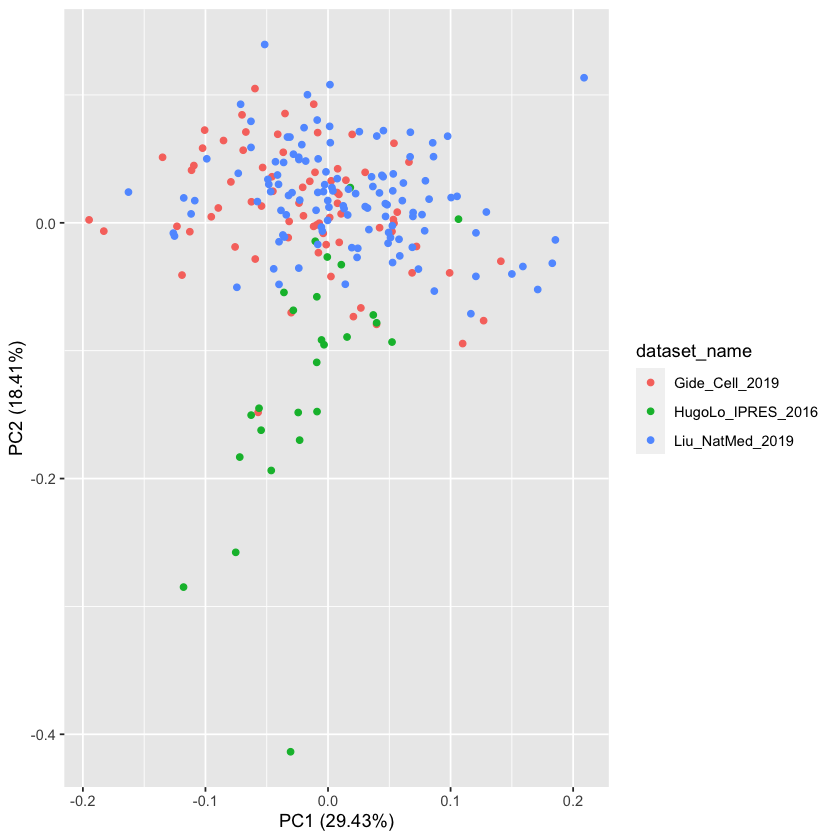

In [42]:
#Let's store the variable names that need to be normalized
variables_to_transf <- feature_predictors

#Generate a matrix with numerical values in the training datasets
train_data <- fmx_pre %>%
  dplyr::filter(dataset_name %in% train) %>%
  dplyr::select(dplyr::any_of(variables_to_transf)) %>% 
  dplyr::mutate(dplyr::across(dplyr::all_of(variables_to_transf), as.numeric))

#a PCA plot, colored by dataset
pca_train <- prcomp(train_data, scale. = TRUE)
autoplot(pca_train, data = fmx_pre %>% filter(dataset_name %in% train), colour = "dataset_name")

Now, let's normalize this data and see if we can reduce batch effects.

## 2.1. Training data


First we standardize the training set, and then we standardize the validation set based on the mean and standard deviation of the training set.

In [43]:
#Standardize the training set, on the dataset level
#before we proceed, let's write a function to normalize the data, 
#considering whether the data will be used for training or testing
norm_datasets <- function(x, test = FALSE, mean_train = NULL, sd_train = NULL){
  x <- as.numeric(x)
  if(test == FALSE){
    if(min(x) == 0 & max(x) == 0) return(NA_integer_) #flag in case all values are 0
    else (x - mean(x))/sd(x)
  }else{ #if we are normalizing validation data, use the average and sd from the training set
    (x - mean_train)/sd_train
  }
}


fmx_train <- data.frame(fmx_pre %>%
  dplyr::filter(dataset_name %in% train) %>%
  dplyr::group_by(dataset_name) %>% #samples will be normalized using the average and sd from the their dataset 
  dplyr::mutate(dplyr::across(dplyr::all_of(variables_to_transf), norm_datasets)) %>% #
  dplyr::ungroup() %>%
  dplyr::select(sample_name, "dataset_name", dplyr::all_of(c(outcome_variable, feature_predictors, group_predictors)))
  )
#in case a dataset has all gene measurements = 0, exclude it
fmx_train <- fmx_train[, colSums(is.na(fmx_train)) == 0] 

head(fmx_train)

,sample_name,dataset_name,Responder,IMPRES,Vincent_IPRES_NonResponder,Cytolytic_Score,BIOCARTA_CTLA4_V_Bindea_Th1_Cells,ADORA2A,CTLA4,EDNRB,TLR4,Immune_Subtype
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,Gide_Cell_2019-iP01-ar-888,Gide_Cell_2019,false_responder,-2.1926598,0.1299035,-1.1527049,-2.5639541,-0.1467975,-0.3561842,1.8664159,-0.4640567,C4
2,Gide_Cell_2019-iP02-ar-898,Gide_Cell_2019,false_responder,-0.3457656,0.8875015,-0.3494564,-0.5537269,0.3994827,-0.3019728,-0.3895282,-0.8176223,C4
3,Gide_Cell_2019-iP06-ar-924,Gide_Cell_2019,false_responder,0.2698658,-0.7559113,0.1207664,0.4961255,-0.1138076,-0.3541011,2.5876218,-0.5097232,C3
4,Gide_Cell_2019-iP07-ar-562,Gide_Cell_2019,true_responder,-1.5770284,-1.1450006,0.1772867,0.3127914,-0.1797874,-0.1852054,-0.1181888,0.6426525,C4
5,Gide_Cell_2019-iP08-ar-926,Gide_Cell_2019,false_responder,-0.3457656,-2.0564492,-1.2800551,0.2841756,-0.1797874,-0.4354192,-0.2779490,-1.0571096,C4
6,Gide_Cell_2019-iP10-ar-889,Gide_Cell_2019,false_responder,-0.9613970,0.3882091,-1.7973893,-1.0205727,-0.1797874,-0.5646994,-0.5241041,-1.0697435,C1


Now that we have a normalized training dataset, let's take a look of heatmaps of the data.

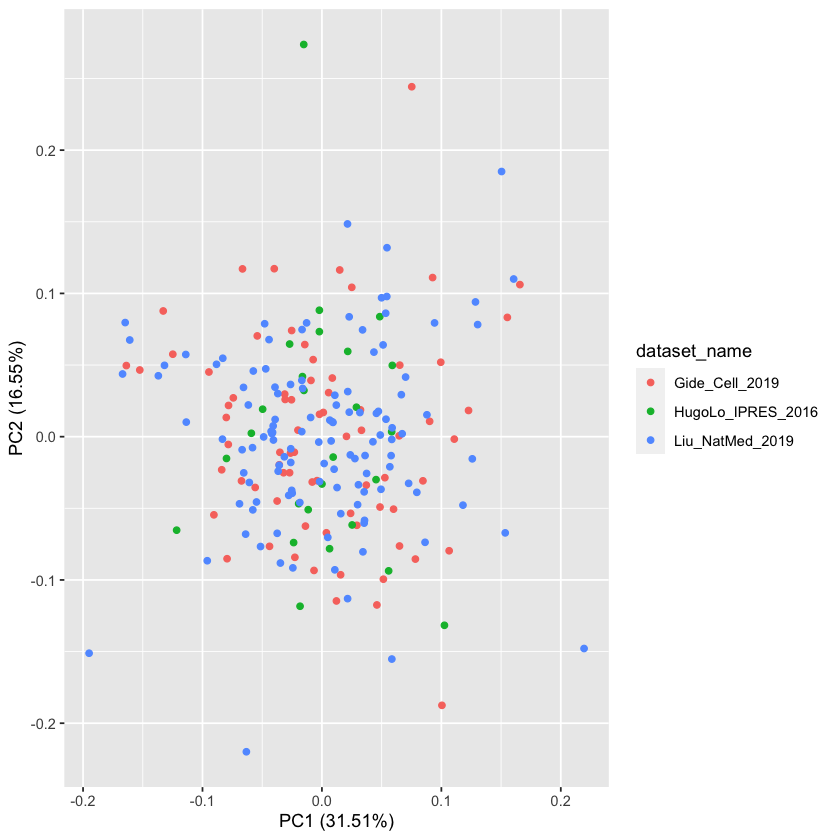

In [44]:
#Generate a matrix with numerical values in the normalized training datasets
norm_train_data <- fmx_train %>%
  dplyr::filter(dataset_name %in% train) %>%
  dplyr::select(dplyr::any_of(variables_to_transf)) %>% 
  dplyr::mutate(across(dplyr::all_of(variables_to_transf), as.numeric))

#a PCA plot, colored by dataset
pca_train <- prcomp(norm_train_data, scale. = TRUE)
autoplot(pca_train, data = fmx_train %>% filter(dataset_name %in% train), colour = "dataset_name")

We can see that the normalization reduced potential batch effects, so we are going to use the fmx_train dataframe for training. 

## 2.2. Testing data

Now that we processed the training dataset, we can adjust the validation dataset. We will use the mean and standard deviation of the training data to normalize the validation data.

In [45]:
#first: computing the mean and sd for gene expression data in the training dataset
train_mean <- colMeans((fmx_pre %>% filter(dataset_name %in% train))[,variables_to_transf])
train_sd <- apply((fmx_pre %>% filter(dataset_name %in% train))[,variables_to_transf], 2, sd)

fmx_test <- data.frame(fmx_pre %>%
  filter(dataset_name %in% test) %>%
  mutate(across(all_of(variables_to_transf), 
                ~norm_datasets(.x, 
                             test = TRUE, 
                             mean_train = train_mean[cur_column()], 
                             sd_train = train_sd[cur_column()]))) %>%
  select(sample_name, Responder, dataset_name, all_of(c(feature_predictors, group_predictors)))
  )

# 3. Random Forest

## 3.1. Training

We will run the `train` function from the `caret` R package:

In [46]:
set.seed(42)
# the following will split the k-folds selected in a way that each fold has a similar proportion 
#of responders as in the complete training dataset
cvIndex <- caret::createFolds(y = factor(fmx_train[[outcome_variable]]), k = n_cv, returnTrain = TRUE)

#formatting the formula for the training function
parameters <- as.formula(paste(outcome_variable, "~ ", paste0(sprintf("`%s`", c(feature_predictors, group_predictors)), collapse = "+")))
#training
en_model <- train(
  parameters, data = fmx_train %>% select(!c(sample_name, dataset_name)), method = "rf",
  trControl = trainControl(index = cvIndex, "cv", number = n_cv),
  tuneLength = 5
)

Elastic net regression involves the use of two parameters, alpha and lambda, and the training of the model involves testing different values for these parameters. We will use the model that had the best accuracy performance (you might have a different idea on how to select the best values for these parameters, so make any adjustments in this step that you find necessary).  

In [47]:
# What is the accuracy of the model with the best parameter tune?
en_model$results[rownames(en_model$bestTune),]

,mtry,Accuracy,Kappa,AccuracySD,KappaSD
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,4,0.6579281,0.3082178,0.06013698,0.127475


If you are happy with this accuracy, let's proceed and take a closer look at the coefficients of the model. (If you're not, make any adjustments that you think might be useful).

In [48]:
var_importance <- caret::varImp(en_model)
var_importance

rf variable importance

                                  Overall
BIOCARTA_CTLA4_V_Bindea_Th1_Cells 100.000
Cytolytic_Score                    88.479
CTLA4                              86.557
Vincent_IPRES_NonResponder         80.072
TLR4                               68.038
IMPRES                             62.613
EDNRB                              62.432
ADORA2A                            26.223
Immune_SubtypeC2                    5.165
Immune_SubtypeC4                    4.354
Immune_SubtypeC3                    4.039
Immune_SubtypeC6                    0.000

A plot with the coefficients might be more useful to get a better sense of the coefficients.

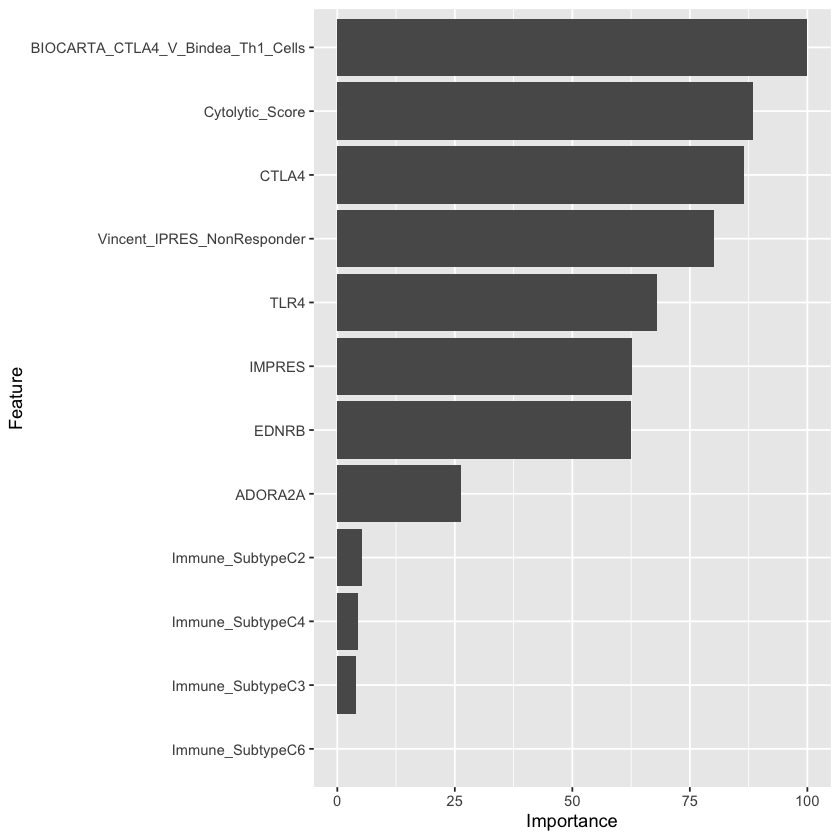

In [49]:
ggplot(var_importance, aes(x, y = reorder(y, x)))+
  geom_bar(stat = 'identity')

## 3.2. Testing

We set aside two datasets for testing the selected model. Let's take a look at the predicted response in these datasets using the model developed in the previous section:

In [50]:
fmx_pred <- purrr::map(.x = test, function(x){
  df <- fmx_test %>% filter(dataset_name == x)
  df$prediction <- predict(en_model, newdata = df)
  df
})
names(fmx_pred) <- test
  
lapply(fmx_pred, function(x) caret::confusionMatrix(x$prediction, as.factor(x[[outcome_variable]]), positive = outcome_annotation[2]))

$Riaz_Nivolumab_2017
Confusion Matrix and Statistics

                 Reference
Prediction        false_responder true_responder
  false_responder               8             31
  true_responder                2              8
                                          
               Accuracy : 0.3265          
                 95% CI : (0.1995, 0.4754)
    No Information Rate : 0.7959          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0025          
                                          
 Mcnemar's Test P-Value : 1.093e-06       
                                          
            Sensitivity : 0.2051          
            Specificity : 0.8000          
         Pos Pred Value : 0.8000          
         Neg Pred Value : 0.2051          
             Prevalence : 0.7959          
         Detection Rate : 0.1633          
   Detection Prevalence : 0.2041          
      Balanced Accuracy : 0.5026         

Warning message in value[[3L]](cond):
“Ordered predictor converted to numeric vector. Threshold values will not correspond to values in predictor.”
Warning message in value[[3L]](cond):
“Ordered predictor converted to numeric vector. Threshold values will not correspond to values in predictor.”


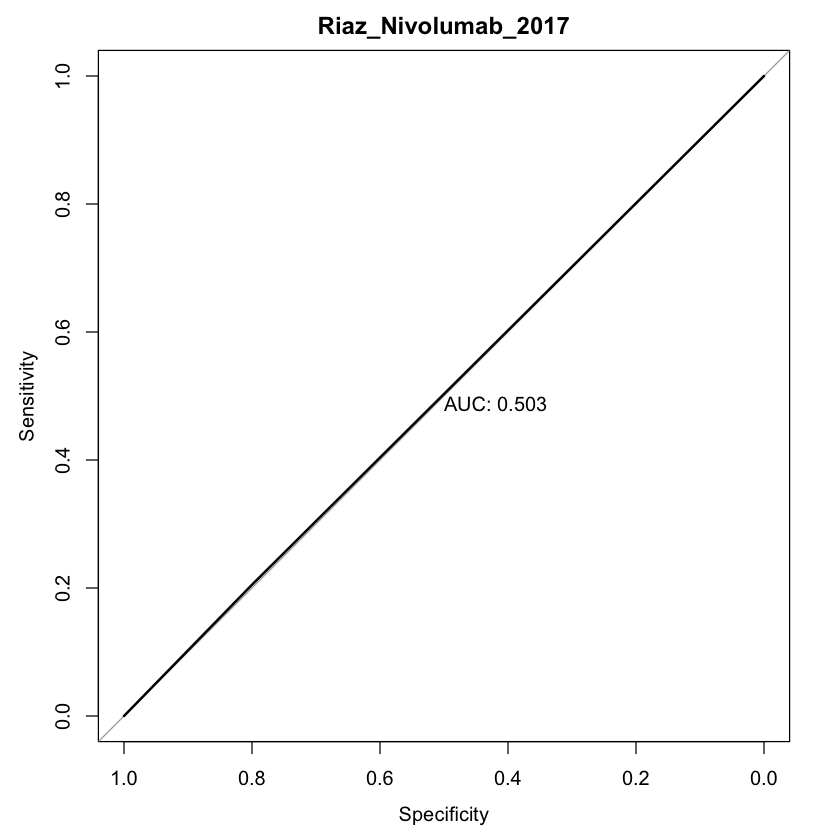

$Riaz_Nivolumab_2017

Call:
roc.default(response = factor(x[[outcome_variable]], ordered = TRUE),     predictor = factor(x$prediction, ordered = TRUE), levels = outcome_annotation,     quiet = TRUE, auc = TRUE)

Data: factor(x$prediction, ordered = TRUE) in 10 controls (factor(x[[outcome_variable]], ordered = TRUE) false_responder) < 39 cases (factor(x[[outcome_variable]], ordered = TRUE) true_responder).
Area under the curve: 0.5026

$VanAllen_antiCTLA4_2015

Call:
roc.default(response = factor(x[[outcome_variable]], ordered = TRUE),     predictor = factor(x$prediction, ordered = TRUE), levels = outcome_annotation,     quiet = TRUE, auc = TRUE)

Data: factor(x$prediction, ordered = TRUE) in 8 controls (factor(x[[outcome_variable]], ordered = TRUE) false_responder) > 33 cases (factor(x[[outcome_variable]], ordered = TRUE) true_responder).
Area under the curve: 0.5379


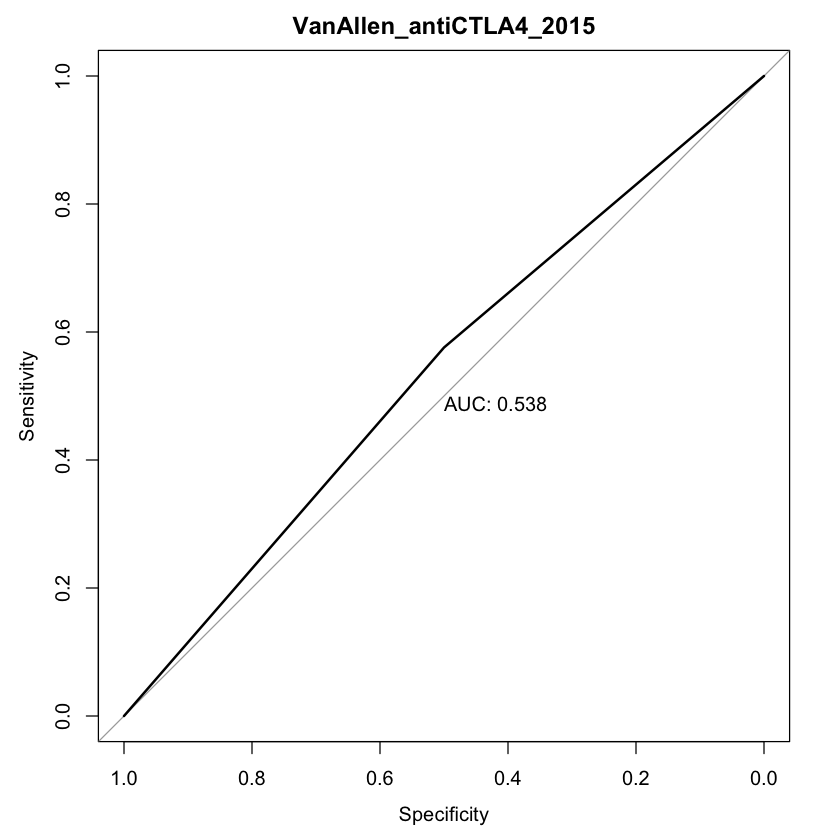

In [51]:
#Let's take a look at the ROC curve
purrr::map(fmx_pred, function(x){
  rplot <- pROC::roc(
  response = factor(x[[outcome_variable]],  ordered = TRUE),
  predictor = factor(x$prediction, ordered = TRUE),
  levels = outcome_annotation,
  quiet = TRUE,
  auc = TRUE
  )
  plot(rplot, print.auc = TRUE, main = unique(x$dataset_name))
})

### 3.2.1. KM Plots 

Lastly, let's use the predicted response as a criteria in a KM plot, with Overall Survival (OS) as endpoint.

$Riaz_Nivolumab_2017

$VanAllen_antiCTLA4_2015


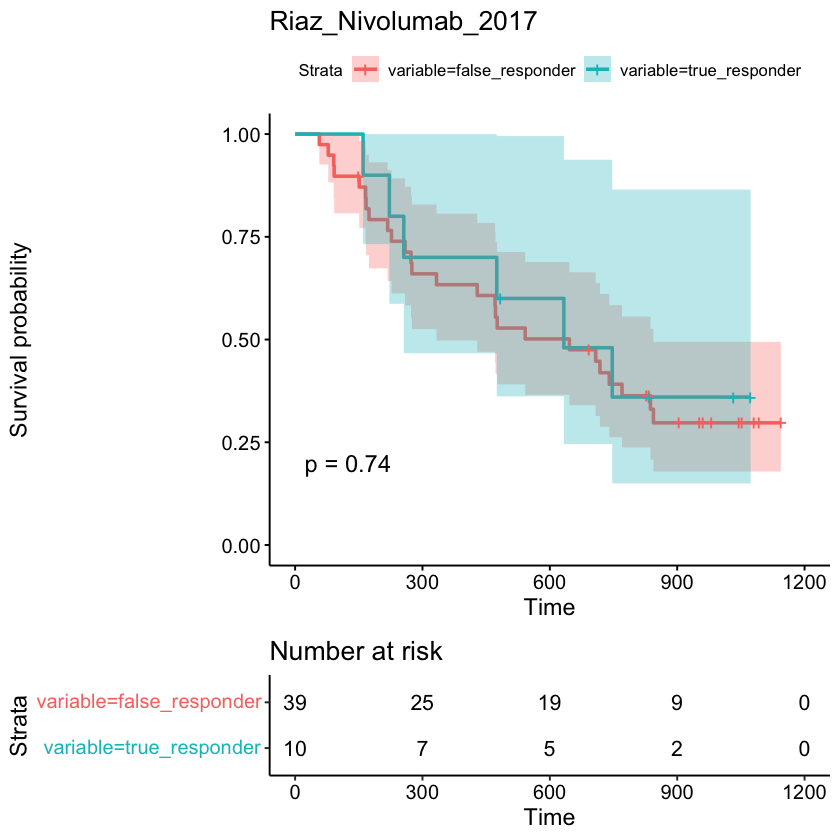

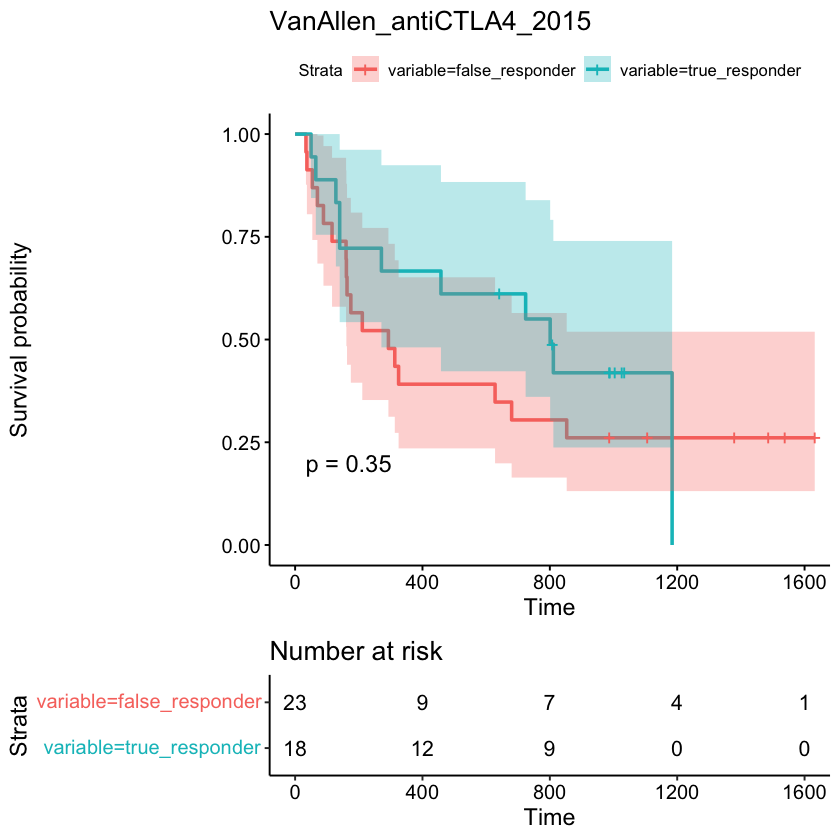

In [52]:
purrr::map(.x = fmx_pred, function(x){
  #get OS data
  km_df <- x %>% 
            inner_join(iatlas.api.client::query_feature_values(features = c("OS", "OS_time")), 
                       by = c("sample_name" = "sample"))%>% 
            get_wide_df(., 
                        names_from_column = "feature_name", 
                        values_from_column = "feature_value", 
                        columns_to_keep = c("sample_name", "dataset_name", "prediction")) %>% 
            mutate(across(all_of(c("OS", "OS_time")), as.numeric))

 #Format data 
  survival_df <- build_survival_df(km_df, var_column = "prediction", time_column = "OS_time", 
                                   status_column = "OS", div_method = "group")
    
  #Build and plot survival curves
  fit <- survival::survfit(survival::Surv(time, status) ~ variable, data = survival_df)
  survminer::ggsurvplot(
        fit,
        data = survival_df,
        conf.int = TRUE,
        risk.table = TRUE,
        title = unique(x$dataset_name),
        pval = TRUE
  )
})

### We would love to hear from you!

That concludes the notebook demonstrating how you can build a Random Forest model using the ICI data in the iAtlas database.

notebook repo: https://github.com/CRI-iAtlas/iatlas-notebooks

landing page:  https://www.cri-iatlas.org/

portal: https://isb-cgc.shinyapps.io/shiny-iatlas/

email:  support@cri-iatlas.org